In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Loading the dataset

In [2]:
from urllib.request import urlretrieve
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
filename = 'household_power_consumption'
urlretrieve(url, filename)

('household_power_consumption', <http.client.HTTPMessage at 0x7f2f4db4d0f0>)

In [3]:
!unzip household_power_consumption

Archive:  household_power_consumption
  inflating: household_power_consumption.txt  


In [4]:
df = pd.read_csv('household_power_consumption.txt', 
                 sep=';', header=0, low_memory=False, 
                 infer_datetime_format=True, 
                 parse_dates={'datetime':[0,1]}, 
                 index_col=['datetime'],
                 na_values='?', dtype= float)
#note that the missing values(na values) were indicated with ?, hence why had to define the type of na values the data contains
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [6]:
df.shape

(2075259, 7)

### Handling missing values

In [7]:
#check for missing values
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [8]:
#fill the missing values
df.fillna(method='ffill', inplace=True)
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### Exploratory analysis

In [9]:
#Downsample to daily data points
df_daily = df.resample('D').sum()
df_daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


Text(0, 0.5, 'Global_active_power')

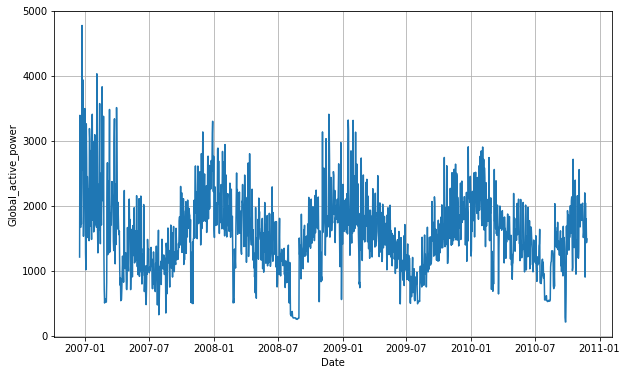

In [10]:
plt.figure(figsize=( 10 , 6 ))
plt.plot(df_daily.index, df_daily.Global_active_power)
plt.grid()
plt.xlabel( 'Date' )
plt.ylabel( 'Global_active_power' )

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


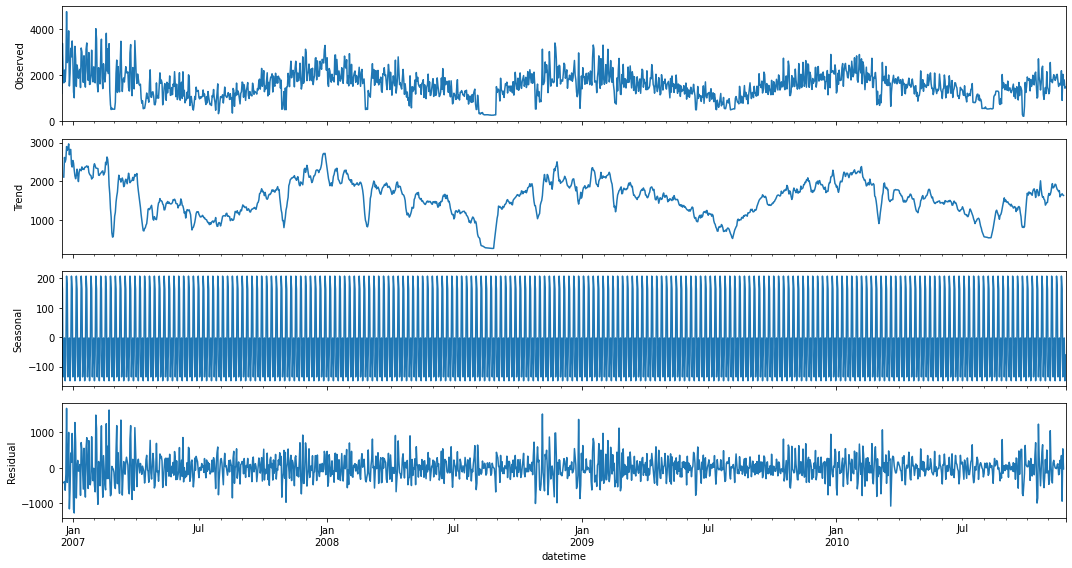

In [11]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize']= 15,8
decompose_series = sm.tsa.seasonal_decompose(df_daily['Global_active_power'], model='addictive')
decompose_series.plot()
plt.show()

### checking for stationarity

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


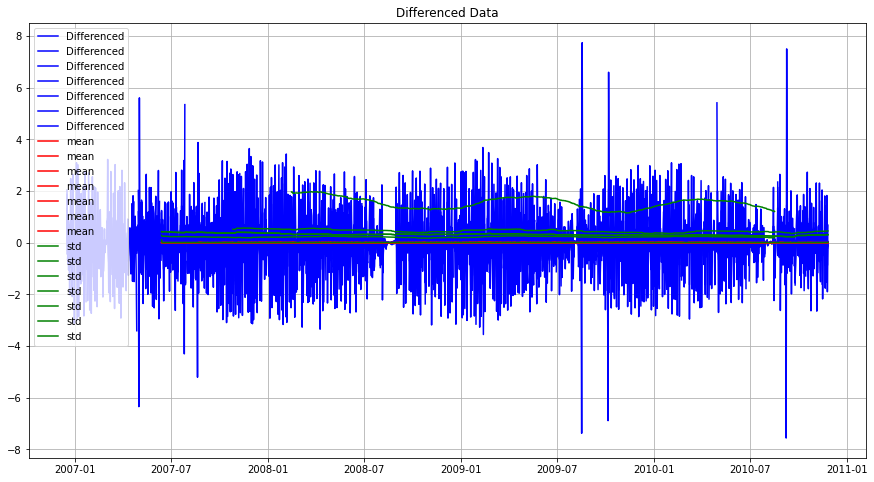

In [12]:
#using the visualization method
df_log=np.log(df_daily)
df_diff = df_log.diff(periods=1)
plt.plot(df_diff, color='blue',label='Differenced')
plt.plot(df_diff.rolling(180).mean(),color = 'red', label='mean')
plt.plot(df_diff.rolling(180).std(), color='green', label='std')
plt.title('Differenced Data')
plt.legend(loc='best')
plt.grid()
plt.show()

From the image it can be observed that both the mean and standard devation are relatively stable indicating that the time series is stationary

In [13]:
#using the unit root test method
from statsmodels.tsa.stattools import adfuller
adf = adfuller(df_daily['Global_active_power'])
print(f'Adf statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
print(f'no of lags used: {adf[2]}')
print(f'no of observations: {adf[3]}  ')
print('Critical values:')
for k, v in adf[4].items():
  print(f'  {k}: {v}')

Adf statistic: -3.7600523102137893
p-value: 0.0033435208887408374
no of lags used: 22
no of observations: 1419  
Critical values:
  1%: -3.434966750462565
  5%: -2.8635789736973725
  10%: -2.5678555388041384


The unit root test gave a p-value of 0.003 which is less than 0.05, that means the time series is stationary

### Pearson Correlation

In [14]:
from scipy.stats import pearsonr 
corr, _ = pearsonr(df['Global_active_power'], df['Global_reactive_power']) 
print('Pearsons correlation between Global active power and Global reactive power: %.3f' % corr)

Pearsons correlation between Global active power and Global reactive power: 0.246


In [15]:
corr1, _ = pearsonr(df['Voltage'], df['Global_intensity']) 
print('Pearsons correlation between Voltage and Global intensity: %.3f' % corr1)

Pearsons correlation between Voltage and Global intensity: -0.407


### Preprocessing

In [16]:
df_daily2 = df_daily.reset_index()

In [17]:
df_daily2.shape

(1442, 8)

In [18]:
dff = df_daily2[['datetime','Global_active_power']]
dff = dff.rename(columns={"datetime": "ds", "Global_active_power": "y"})
dff.head()

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


In [19]:
train = dff.iloc[:1077]
test= dff.iloc[1077:]

In [20]:
train.shape

(1077, 2)

In [30]:
test.shape
test.dtypes

ds    datetime64[ns]
y            float64
dtype: object

### Modelling

In [22]:
from fbprophet import Prophet
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
future = model.make_future_dataframe(periods = 365, freq='D', include_history = False)
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1565.003639,1506.279733,2673.258693,1565.003639,1565.003639,528.367180,528.367180,528.367180,-59.098498,-59.098498,-59.098498,587.465678,587.465678,587.465678,0.0,0.0,0.0,2093.370819
1,2009-11-28,1565.085671,1805.905065,2965.829255,1565.085671,1565.085671,818.657604,818.657604,818.657604,238.675298,238.675298,238.675298,579.982305,579.982305,579.982305,0.0,0.0,0.0,2383.743274
2,2009-11-29,1565.167702,1811.338934,2928.555643,1565.167702,1565.167702,791.260573,791.260573,791.260573,220.722783,220.722783,220.722783,570.537789,570.537789,570.537789,0.0,0.0,0.0,2356.428275
3,2009-11-30,1565.249733,1431.799399,2544.659414,1565.249733,1565.249733,397.943500,397.943500,397.943500,-161.714901,-161.714901,-161.714901,559.658401,559.658401,559.658401,0.0,0.0,0.0,1963.193233
4,2009-12-01,1565.331764,1525.771815,2643.094652,1565.331764,1565.331764,523.514378,523.514378,523.514378,-24.375264,-24.375264,-24.375264,547.889642,547.889642,547.889642,0.0,0.0,0.0,2088.846143


### Cross validation

In [24]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='711 days', 
                         period='365 days',
                         horizon = '365 days')

INFO:fbprophet:Making 1 forecasts with cutoffs between 2008-11-26 00:00:00 and 2008-11-26 00:00:00


### Performance metrics

In [25]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,384143.816257,619.793366,451.981950,0.351359,0.156990,0.777778
1,37 days,380439.670254,616.797917,442.440298,0.347324,0.149132,0.777778
2,38 days,391304.638774,625.543475,454.688341,0.353678,0.163406,0.750000
3,39 days,402947.171432,634.781200,470.463283,0.362057,0.185618,0.722222
4,40 days,411489.226139,641.474260,485.290236,0.371422,0.203967,0.694444


In [36]:
new_test = test['y'].replace(0, np.nan).fillna(method='ffill')
new_test.index = list(range(365))

In [37]:
MAPE = np.mean(abs(new_test - forecast['yhat'])/new_test) * 100
print('The MAPE is: %.3f' %MAPE)

The MAPE is: 26.237


In [39]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(new_test, forecast['yhat']))
print('The RMSE is: %.3f' %rmse)

The RMSE is: 401.909


### Multivariate analysis

In [43]:
df_daily3 = df_daily2.rename(columns = {'datetime': 'ds', 
                                   'Global_active_power':'y', 
                                   'Global_reactive_power': 'add1',
                                   'Voltage':'add2', 
                                   'Global_intensity':'add3', 
                                   'Sub_metering_1':'add4', 
                                   'Sub_metering_2':'add5',  'Sub_metering_3':'add6'})


In [44]:
train2 = df_daily3.iloc[:1077]
test2 = df_daily3.iloc[1077:]

In [45]:
model2 = Prophet(daily_seasonality=True)
model2.fit(train2)

In [47]:
future2 = model2.make_future_dataframe(periods = 365, freq='D', include_history = False)
forecast2 = model2.predict(future)
forecast2.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1220.171501,1534.700819,2651.598107,1220.171501,1220.171501,874.247092,874.247092,874.247092,345.671279,345.671279,345.671279,-59.093701,-59.093701,-59.093701,587.669513,587.669513,587.669513,0.0,0.0,0.0,2094.418593
1,2009-11-28,1220.257598,1876.433383,2946.825559,1220.257598,1220.257598,1164.546066,1164.546066,1164.546066,345.671279,345.671279,345.671279,238.675756,238.675756,238.675756,580.199031,580.199031,580.199031,0.0,0.0,0.0,2384.803664
2,2009-11-29,1220.343695,1773.959391,2925.305796,1220.343695,1220.343695,1137.159187,1137.159187,1137.159187,345.671279,345.671279,345.671279,220.722751,220.722751,220.722751,570.765157,570.765157,570.765157,0.0,0.0,0.0,2357.502882
3,2009-11-30,1220.429792,1394.425384,2500.201153,1220.429792,1220.429792,743.850189,743.850189,743.850189,345.671279,345.671279,345.671279,-161.715001,-161.715001,-161.715001,559.893911,559.893911,559.893911,0.0,0.0,0.0,1964.279981
4,2009-12-01,1220.515889,1556.434762,2673.042804,1220.515889,1220.515889,869.425631,869.425631,869.425631,345.671279,345.671279,345.671279,-24.376235,-24.376235,-24.376235,548.130587,548.130587,548.130587,0.0,0.0,0.0,2089.941519


In [48]:
new_test2 = test2['y'].replace(0, np.nan).fillna(method='ffill')
new_test2.index = list(range(365))

In [50]:
MAPE2 = np.mean(abs(new_test2 - forecast2['yhat'])/new_test2) * 100
print('The MAPE is: %.3f' %MAPE2)

The MAPE is: 26.268


In [52]:
rmse2 = np.sqrt(mean_squared_error(new_test2, forecast2['yhat']))
print('The RMSE is: %.3f' %rmse2)

The RMSE is: 402.016


In [53]:
df_cv2 = cross_validation(model2, initial='711 days', 
                         period='365 days',
                         horizon = '365 days')

INFO:fbprophet:Making 1 forecasts with cutoffs between 2008-11-26 00:00:00 and 2008-11-26 00:00:00


In [54]:
df_p2 = performance_metrics(df_cv2)
df_p2.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,381578.437353,617.720355,450.341544,0.350118,0.156770,0.777778
1,37 days,377852.234911,614.696864,440.669643,0.346027,0.147969,0.777778
2,38 days,388587.202188,623.367630,452.836880,0.352338,0.162632,0.750000
3,39 days,400086.235231,632.523703,468.475725,0.360650,0.184553,0.722222
4,40 days,408510.641496,639.148372,483.165465,0.369937,0.202401,0.722222
